# BERTopic modeling - Using *only* aspect based sentences

Using the documentation provided in here: https://maartengr.github.io/BERTopic/index.html

## Load the required libraries

In [1]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models.coherencemodel import CoherenceModel
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
import pandas as pd
import re
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore")

import plotly.io as pio
pio.renderers.default = "svg"

/Users/apgopala/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load the required Data set and do basic cleaning of the reviews field

In [2]:
# Load the data set
df = pd.read_csv('ca_restaurants.csv')

In [3]:
# Create the copy of the data set
sample_df = df.copy()

In [4]:
# Print one of the review
sample_df['text'].values[0:1]

array(["Had a party of 6 here for hibachi. Our waitress brought our separate sushi orders on one plate so we couldn't really tell who's was who's and forgot several items on an order. I understand making mistakes but the restaraunt was really quiet so we were kind of surprised. Usually hibachi is a fun lively experience and our  cook  said maybe three words, but he cooked very well his name was Francisco. Service was fishy, food was pretty good, and im hoping it was just an off night here. But for the money I wouldn't go back."],
      dtype=object)

In [5]:
# Convert the reviews text data into str format
sample_df['text'] = sample_df['text'].astype('str')

# Convert the reviews text data into lower
sample_df['text'] = sample_df['text'].apply(lambda x : x.lower())

In [6]:
# Print first row of review data set
sample_df['text'].head(1)

0    had a party of 6 here for hibachi. our waitres...
Name: text, dtype: object

## Data Preprocessing of data prior to training the BERTopic model

#### Aspect based words

In [7]:
aspect_str = """Environment
Setting
Mood
Vibes
Decor
Surroundings
Aura
Character
Tone
Feeling
Atmosphere
Environment
Ambiance
Vibe
Mood
Setting
Aura
Tone
Feel
Spirit
Climate
Dessert
Sweet treats
Confections
Pastries
Sweets
After-dinner delights
Pudding
Treats
Goodies
Delicacies
Sundaes
Drinks
Beverages
Cocktails
Refreshments
Libations
Potations
Brews
Tipples
Elixirs
Quenchers
Sips
Entertainment
Amusement
Recreation
Leisure activities
Fun
Enjoyment
Distraction
Diversions
Leisure
Pleasure
Pastime
Experience
Encounter
Event
Adventure
Journey
Perception
Impressions
Occasion
Observation
Encounter
Interaction
Food Taste
Flavor
Taste
Palate
Savory
Deliciousness
Savoriness
Tastiness
Flavorsome
Yumminess
Appetizing
Food Portion
Serving size
Quantity
Portion size
Amount
Helping
Size
Serving
Proportion
Adequacy
Bulk
Kid Friendly
Family-friendly
Child-friendly
Suitable for kids
Safe for children
Geared toward children
Appropriate for families
Family-oriented
Child-welcoming
Friendly for kids
Catering to children
Location
Place
Position
Locale
Site
Spot
Area
Positioning
Venue
Venue
Site
Price
Cost
Expense
Pricing
Fee
Charge
Rate
Value
Affordability
Price tag
Costliness
Seating
Sitting
Chairs
Seats
Benches
Sitting arrangement
Perch
Placement
Seating plan
Sitting accommodations
Places to sit
Service
Assistance
Help
Support
Aid
Customer service
Attentiveness
Hospitality
Care
Treatment
Service quality
Setting
Environment
Ambiance
Surroundings
Scene
Locale
Location
Atmosphere
Background
Situation
Context
Space
Area
Room
Place
Capacity
Size
Volume
Roominess
Spaciousness
Extent
Dimensions
Utilities
Services
Amenities
Facilities
Features
Conveniences
Resources
Tools
Assets
Infrastructure
Necessities
Waiting Time
Wait
Queuing time
Downtime
Delay
Holdup
Pause
Lag
Standby time
Interval
Time to wait"""

In [8]:
# Convert the aspect words to lower
aspects = list(set(aspect_str.lower().split('\n')))

#### Only keep the review sentences which only has aspect words

In [9]:
def keepAspectSentences(x):
    '''
    Only keep the sentences from the review text 
    that has aspect related words
    '''
    aspect_sent=''
    for sent in x.split('.'): #split the review text
        for s in aspects:
            enriched = " " + s + " "
            if enriched in sent: # if aspect is in sentences, then keep that
                if aspect_sent: 
                    aspect_sent = aspect_sent + '. ' + sent
                else:
                    aspect_sent = sent
        return aspect_sent

In [10]:
sample_df['text'] = sample_df['text'].apply(lambda x: keepAspectSentences(x))

#### Remove stopwords from the review text 

In [11]:
stopwords = list(["a", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"])

In [12]:
def removeStopwords(x):
    '''
    Remove stop words from the review text 
    '''
    for s in stopwords:
        enriched = " " + s + " "
        if enriched in x:
            x = x.replace(enriched, " ")
    return x

In [13]:
sample_df['text'] = sample_df['text'].apply(lambda x: removeStopwords(x))

In [14]:
# Get the reviews data when it is not null and load it into 'docs'
docs = sample_df[sample_df['text']!='']['text'].values

## BERTopic modeling

In [15]:
# Specifying specific seed words
ctfidf_model = ClassTfidfTransformer(
    seed_words=['ambiance','atmosphere','dessert','drinks','entertainment','experience','food','food portion','kid friendly',\
          'location','price','seating','service','setting','space','utilities','waiting time', 'group friendly', 'noise level',\
          'food expensive'], 
    seed_multiplier=2
)

In [16]:
# We are using the KeyBERTInspired model which speeds up inference
representation_model = KeyBERTInspired()

# Use the keybert model and the additional classtfidf. 
# Set the number of topics to 29 and the minimum topic size to 100 
# to get decent sized clusters
topic_model = BERTopic(representation_model=representation_model, \
                       ctfidf_model=ctfidf_model,\
                       language="english", # the following default embedding model is used "all-MiniLM-L6-v2"
                       calculate_probabilities=True,\
                       verbose=True, 
                       nr_topics=29, # using the same number of Topics as what was used in LDA 
                       min_topic_size=100)

# Once the model is initialized, call the fit transform on the reviews data
topics, probs = topic_model.fit_transform(docs)

# Get the topic information
freq = topic_model.get_topic_info();

2024-04-18 08:45:07,742 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2254 [00:00<?, ?it/s]

2024-04-18 08:47:48,984 - BERTopic - Embedding - Completed ✓
2024-04-18 08:47:48,985 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-18 08:48:38,161 - BERTopic - Dimensionality - Completed ✓
2024-04-18 08:48:38,166 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-18 08:49:19,916 - BERTopic - Cluster - Completed ✓
2024-04-18 08:49:19,921 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-18 08:49:26,723 - BERTopic - Representation - Completed ✓
2024-04-18 08:49:26,724 - BERTopic - Topic reduction - Reducing number of topics
2024-04-18 08:49:29,616 - BERTopic - Topic reduction - Reduced number of topics from 114 to 29


In [17]:
# Print the topic details
freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,26312,-1_restaurant_service_meal_food,"[restaurant, service, meal, food, dining, lunc...",[this restaurant sb food delicious service ama...
1,0,11841,0_restaurant_dining_meal_service,"[restaurant, dining, meal, service, food, lunc...","[great food great service eat breakfast here, ..."
2,1,5868,1_barbara_cafe_place_restaurants,"[barbara, cafe, place, restaurants, restaurant...","[favorite place santa barbara, this place sant..."
3,2,3741,2_winery_wines_wineries_wine,"[winery, wines, wineries, wine, brewery, beers...",[this spot great atmosphere excellent selectio...
4,3,3595,3_service_restaurant_food_waiter,"[service, restaurant, food, waiter, customers,...","[great service good food, food service good, g..."
5,4,3064,4_zone_funk_place_venue,"[zone, funk, place, venue, area, located, loca...","[this cute tasting room funk zone, this favori..."
6,5,2758,5_seating_patio_indoor_outdoor,"[seating, patio, indoor, outdoor, dining, rest...",[super excellent brunch service! outdoor seati...
7,6,1946,6_ice_dessert_cream_place,"[ice, dessert, cream, place, smoothie, smoothi...","[this place good ice cream, this place good ic..."
8,7,1251,7_stars_star_stellar_5stars,"[stars, star, stellar, 5stars, 5star, space, f...","[i place stars, the food 4 stars service 3 sta..."
9,8,1159,8_rooms_hotel_hotels_room,"[rooms, hotel, hotels, room, tasting, motel, b...",[friendly tasting room staff priced tasting ($...


In [18]:
# Save the results 
freq.to_csv('berttopic_results_only_aspect_sentences.csv')

In [19]:
# Looking at the words from the most frequent topic
topic_model.get_topic(0) 

[('restaurant', 0.5880003),
 ('dining', 0.5076683),
 ('meal', 0.47104913),
 ('service', 0.45665473),
 ('food', 0.44381425),
 ('lunch', 0.4378066),
 ('burgers', 0.4375628),
 ('burger', 0.411482),
 ('sandwiches', 0.39256454),
 ('seafood', 0.3709221)]

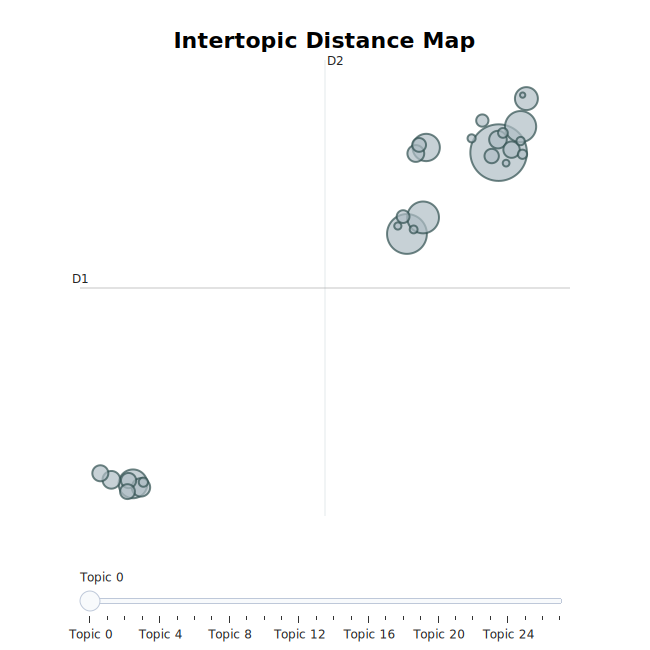

In [20]:
# Visualize the intertopic distance

topic_model.visualize_topics()

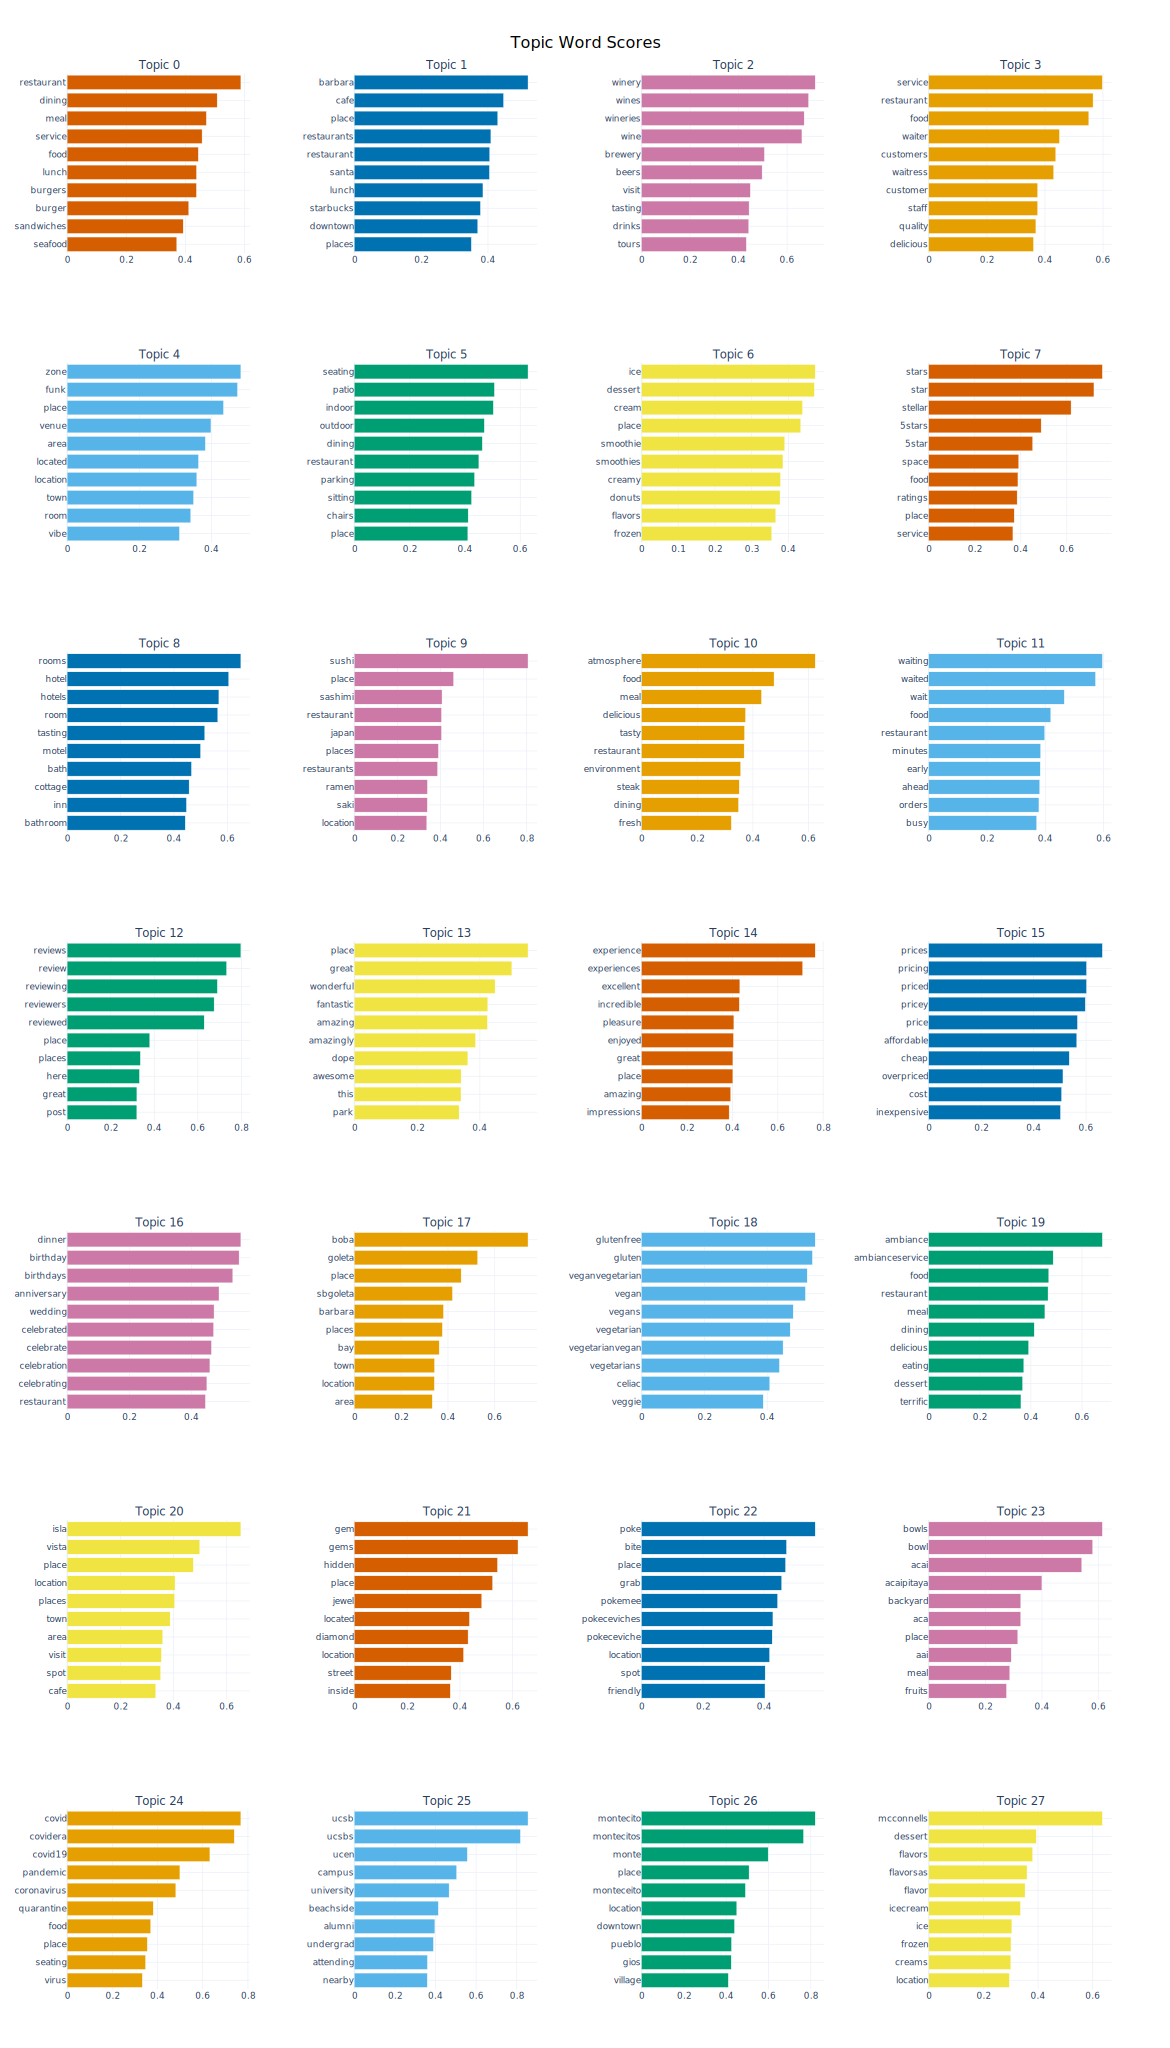

In [21]:
# Visualize the topics and words in each
topic_model.visualize_barchart(n_words=10, width=400, height=400, top_n_topics=29)

In [22]:
# Save the topic model results
fig = topic_model.visualize_barchart(n_words=5, width=400, height=200, top_n_topics=29)
fig.write_html("bertopic_aspect_based_sentences.html")

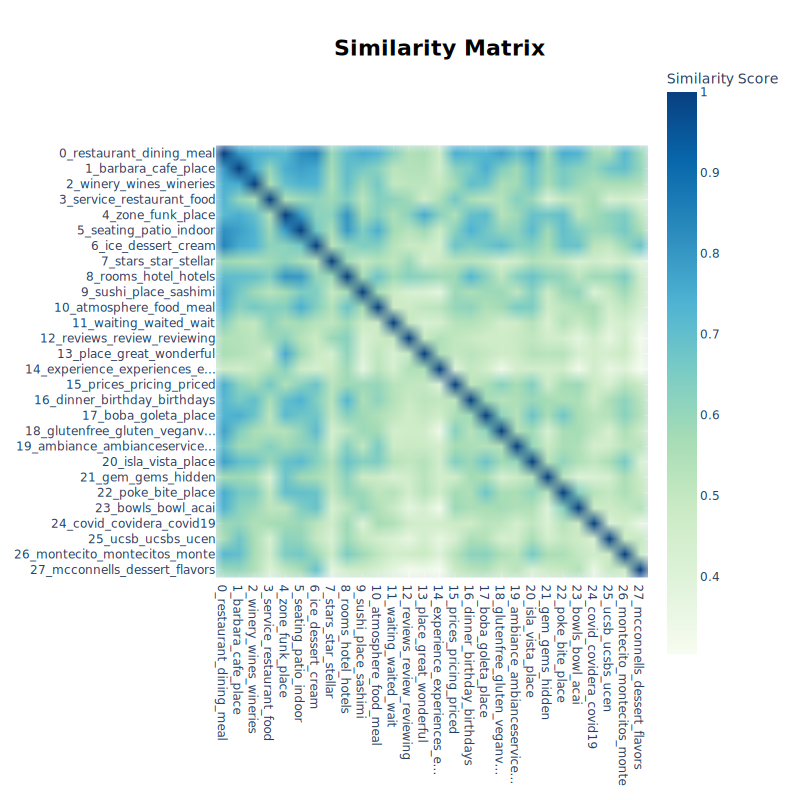

In [23]:
# The similarity matrix tells us how similar certain topics are to each other and it is calcualted using cosine similarity
topic_model.visualize_heatmap()

In [24]:
bertopic_distributions = topic_model.transform(docs)[1]

Batches:   0%|          | 0/2254 [00:00<?, ?it/s]

2024-04-18 08:51:52,862 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-04-18 08:51:53,218 - BERTopic - Dimensionality - Completed ✓
2024-04-18 08:51:53,221 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-04-18 08:52:00,389 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-04-18 08:52:46,698 - BERTopic - Probabilities - Completed ✓
2024-04-18 08:52:46,699 - BERTopic - Cluster - Completed ✓


In [25]:
import numpy as np
np.save('bertopic_aspect_based_sentences', bertopic_distributions)

In [26]:
# Done